**Binary Classification | Software Defects**

*Goal: Predict defects in C programs given various various attributes about the code.*

The challenge in this competition revolves around binary classification for detecting software defects using synthetic dataset that was generated from a deep learning model trained on the Software Defect Dataset. The performance metric employed to assess the models is the area under the ROC curve (Receiver Operating Characteristic curve). - github

**Data Describtion**

Here is a describtion of data taken from about JM1 Dataset.txt document from the original data source on Kaggle (https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction?select=about+JM1+Dataset.txt).


1. loc             : McCabe's line count of code
2. v(g)            : McCabe "cyclomatic complexity"
3. ev(g)           : McCabe "essential complexity"
4. iv(g)           : McCabe "design complexity"
5. n               : Halstead total operators + operands
6. v               : Halstead "volume"
7. l               : Halstead "program length"
8. d               : Halstead "difficulty"
9. i               : Halstead "intelligence"
10. e              : Halstead "effort"
11. b              : Halstead 
12. t              : Halstead's time estimator
13. lOCode         : Halstead's line count
14. lOComment      : Halstead's count of lines of comments     
15. lOBlank        : Halstead's count of blank lines
16. locCodeAndComment: 
17. uniq_Op         : unique operators
18. uniq_Opnd       : unique operands
19. total_Op        : total operators
20. total_Opnd      : total operands
21. branchCount     : of the flow graph
22. defects         : {false,true} module has/has not one or more reported defectss

*You can read more about McCabe and Halstead code metrics in README.md*

**Files**

train.csv - the training dataset; defects is the binary target, which is treated as a boolean (False=0, True=1)

test.csv - the test dataset; your objective is to predict the probability of positive defects (i.e., defects=True)

**Import Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import squareform

from catboost import *

In [2]:
train_df = pd.read_csv('train_software.csv')
test_df = pd.read_csv('test_software.csv')

**Data analysis**

In [3]:
train_df.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
print(train_df.shape)
print(test_df.shape)

(101763, 23)
(67842, 22)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [6]:
train_df.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


The description shows that there are no null values in the dataset

<Axes: xlabel='defects'>

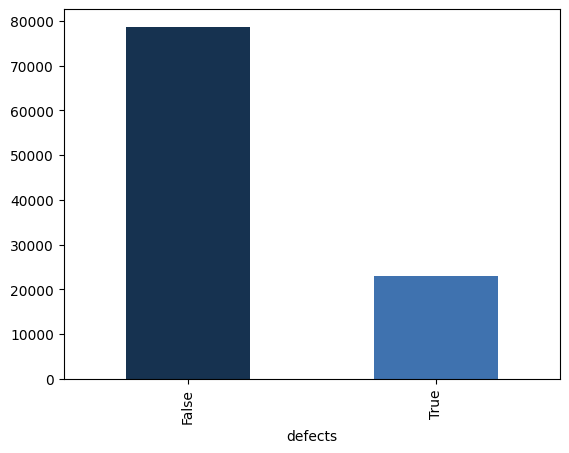

In [7]:
palette = ["#163250", "#3F72AF"]
train_df.defects.value_counts().plot(kind="bar", color=palette)


In [8]:
y = train_df['defects']
X = train_df.drop(['defects', 'id'], axis=1)

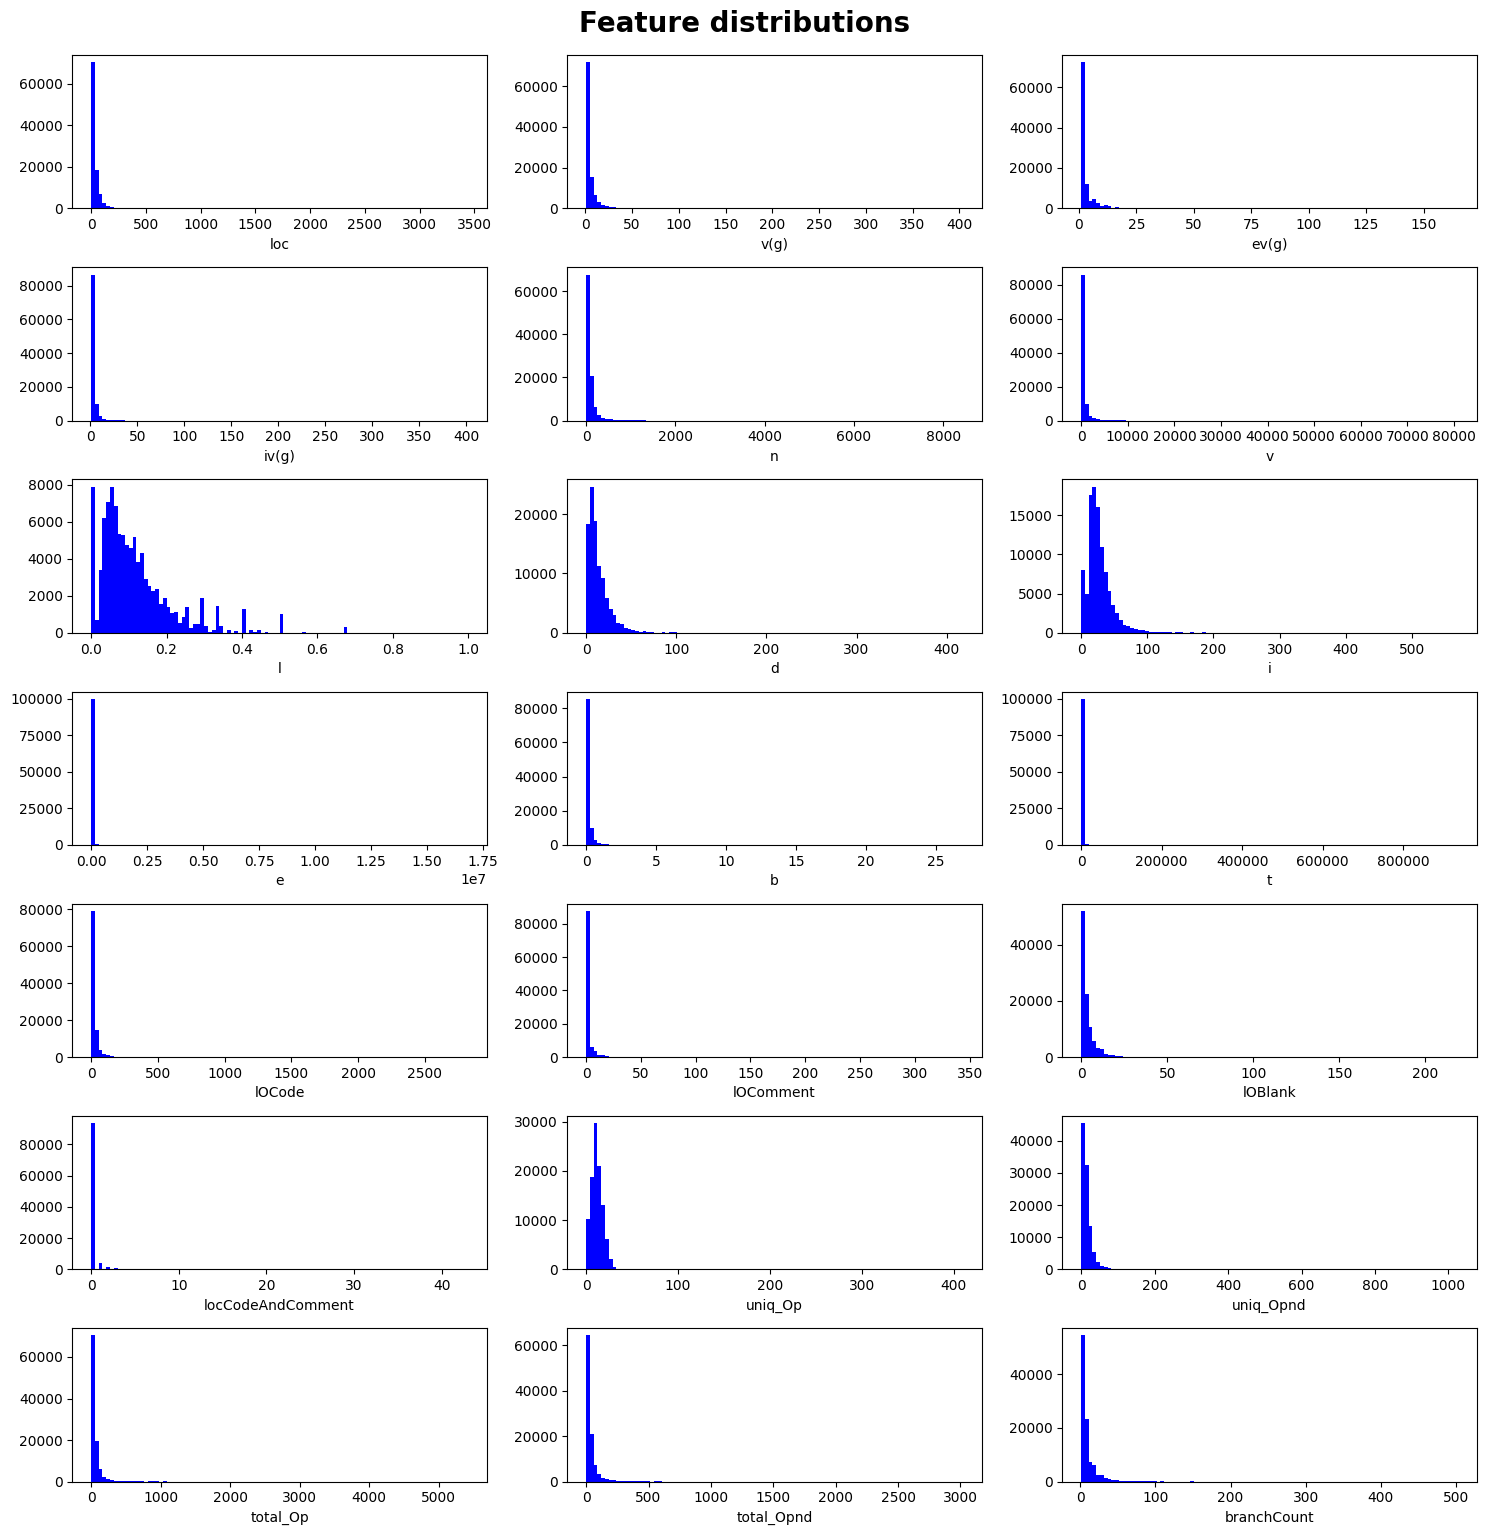

In [9]:
fig, axs = plt.subplots(7, 3, figsize = (15, 15))

for col, ax in zip(X.columns, axs.ravel()):    
    ax.hist(X[col], bins=100, color='blue')
    ax.set_xlabel(col)
    
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize = 20, fontweight = 'bold')
plt.show()


**Information Gain**

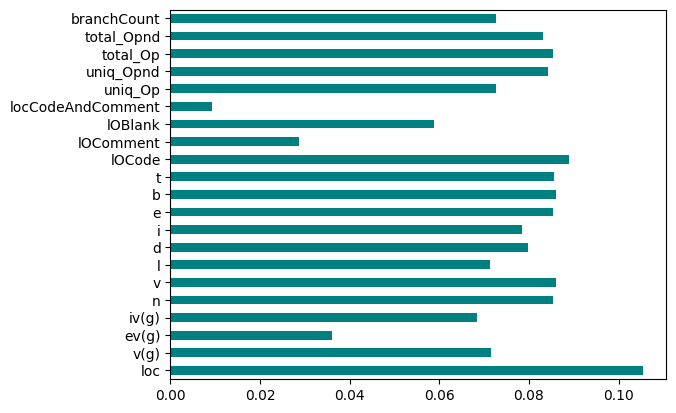

In [10]:
importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, train_df.columns[1:len(train_df.columns)-1])
feature_importances.plot(kind='barh', color='teal')
plt.show()

We can conclude that loc is one of the most important features

locCodeAndComment and lOComment are not the most important signs

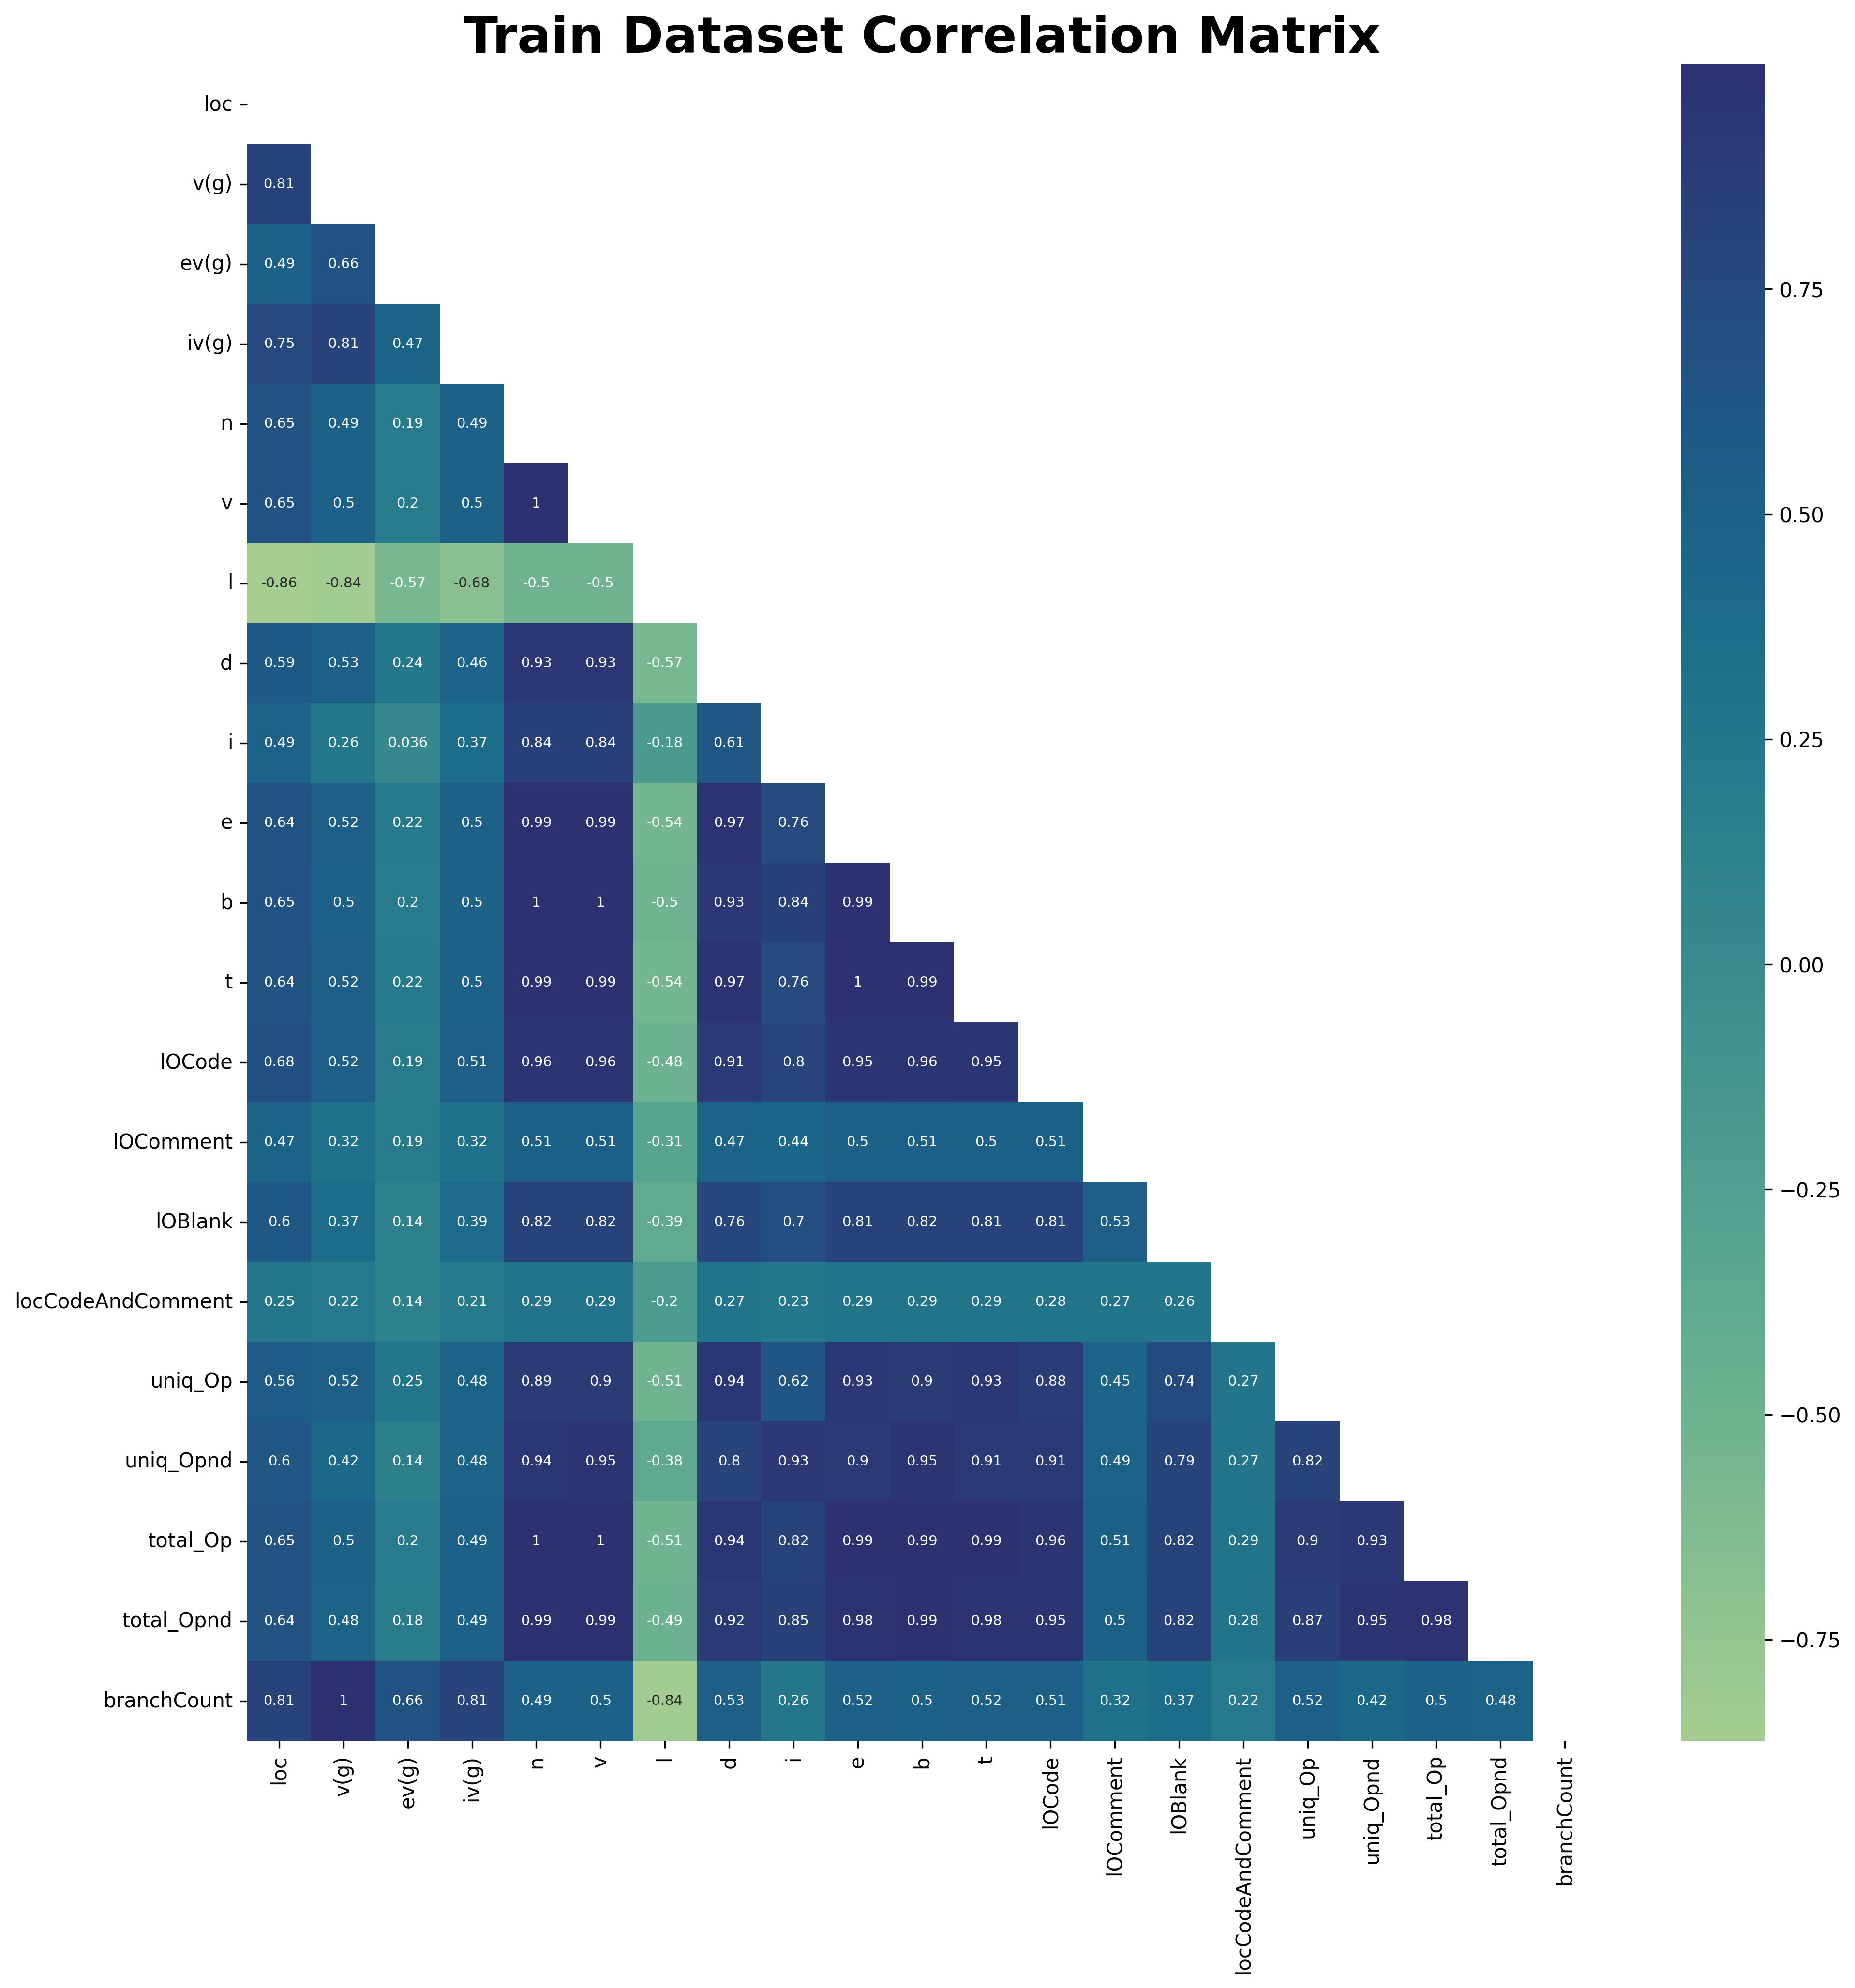

In [11]:
corr = X.corr(method = 'spearman')
plt.figure(figsize = (15, 15), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'crest', annot = True, annot_kws = {'size' : 7})
plt.title('Train Dataset Correlation Matrix', fontsize = 25, weight = 'bold')
plt.show()

There is a 100% correlation between v and n.

There is a 99% correlation between b and e.

There is a 99% correlation between t and b.

There is a 98% correlation between total_Opnd and total_Op.


We can see that there are many features that have a high correlation percentage.

**Hierarchical Clustering**

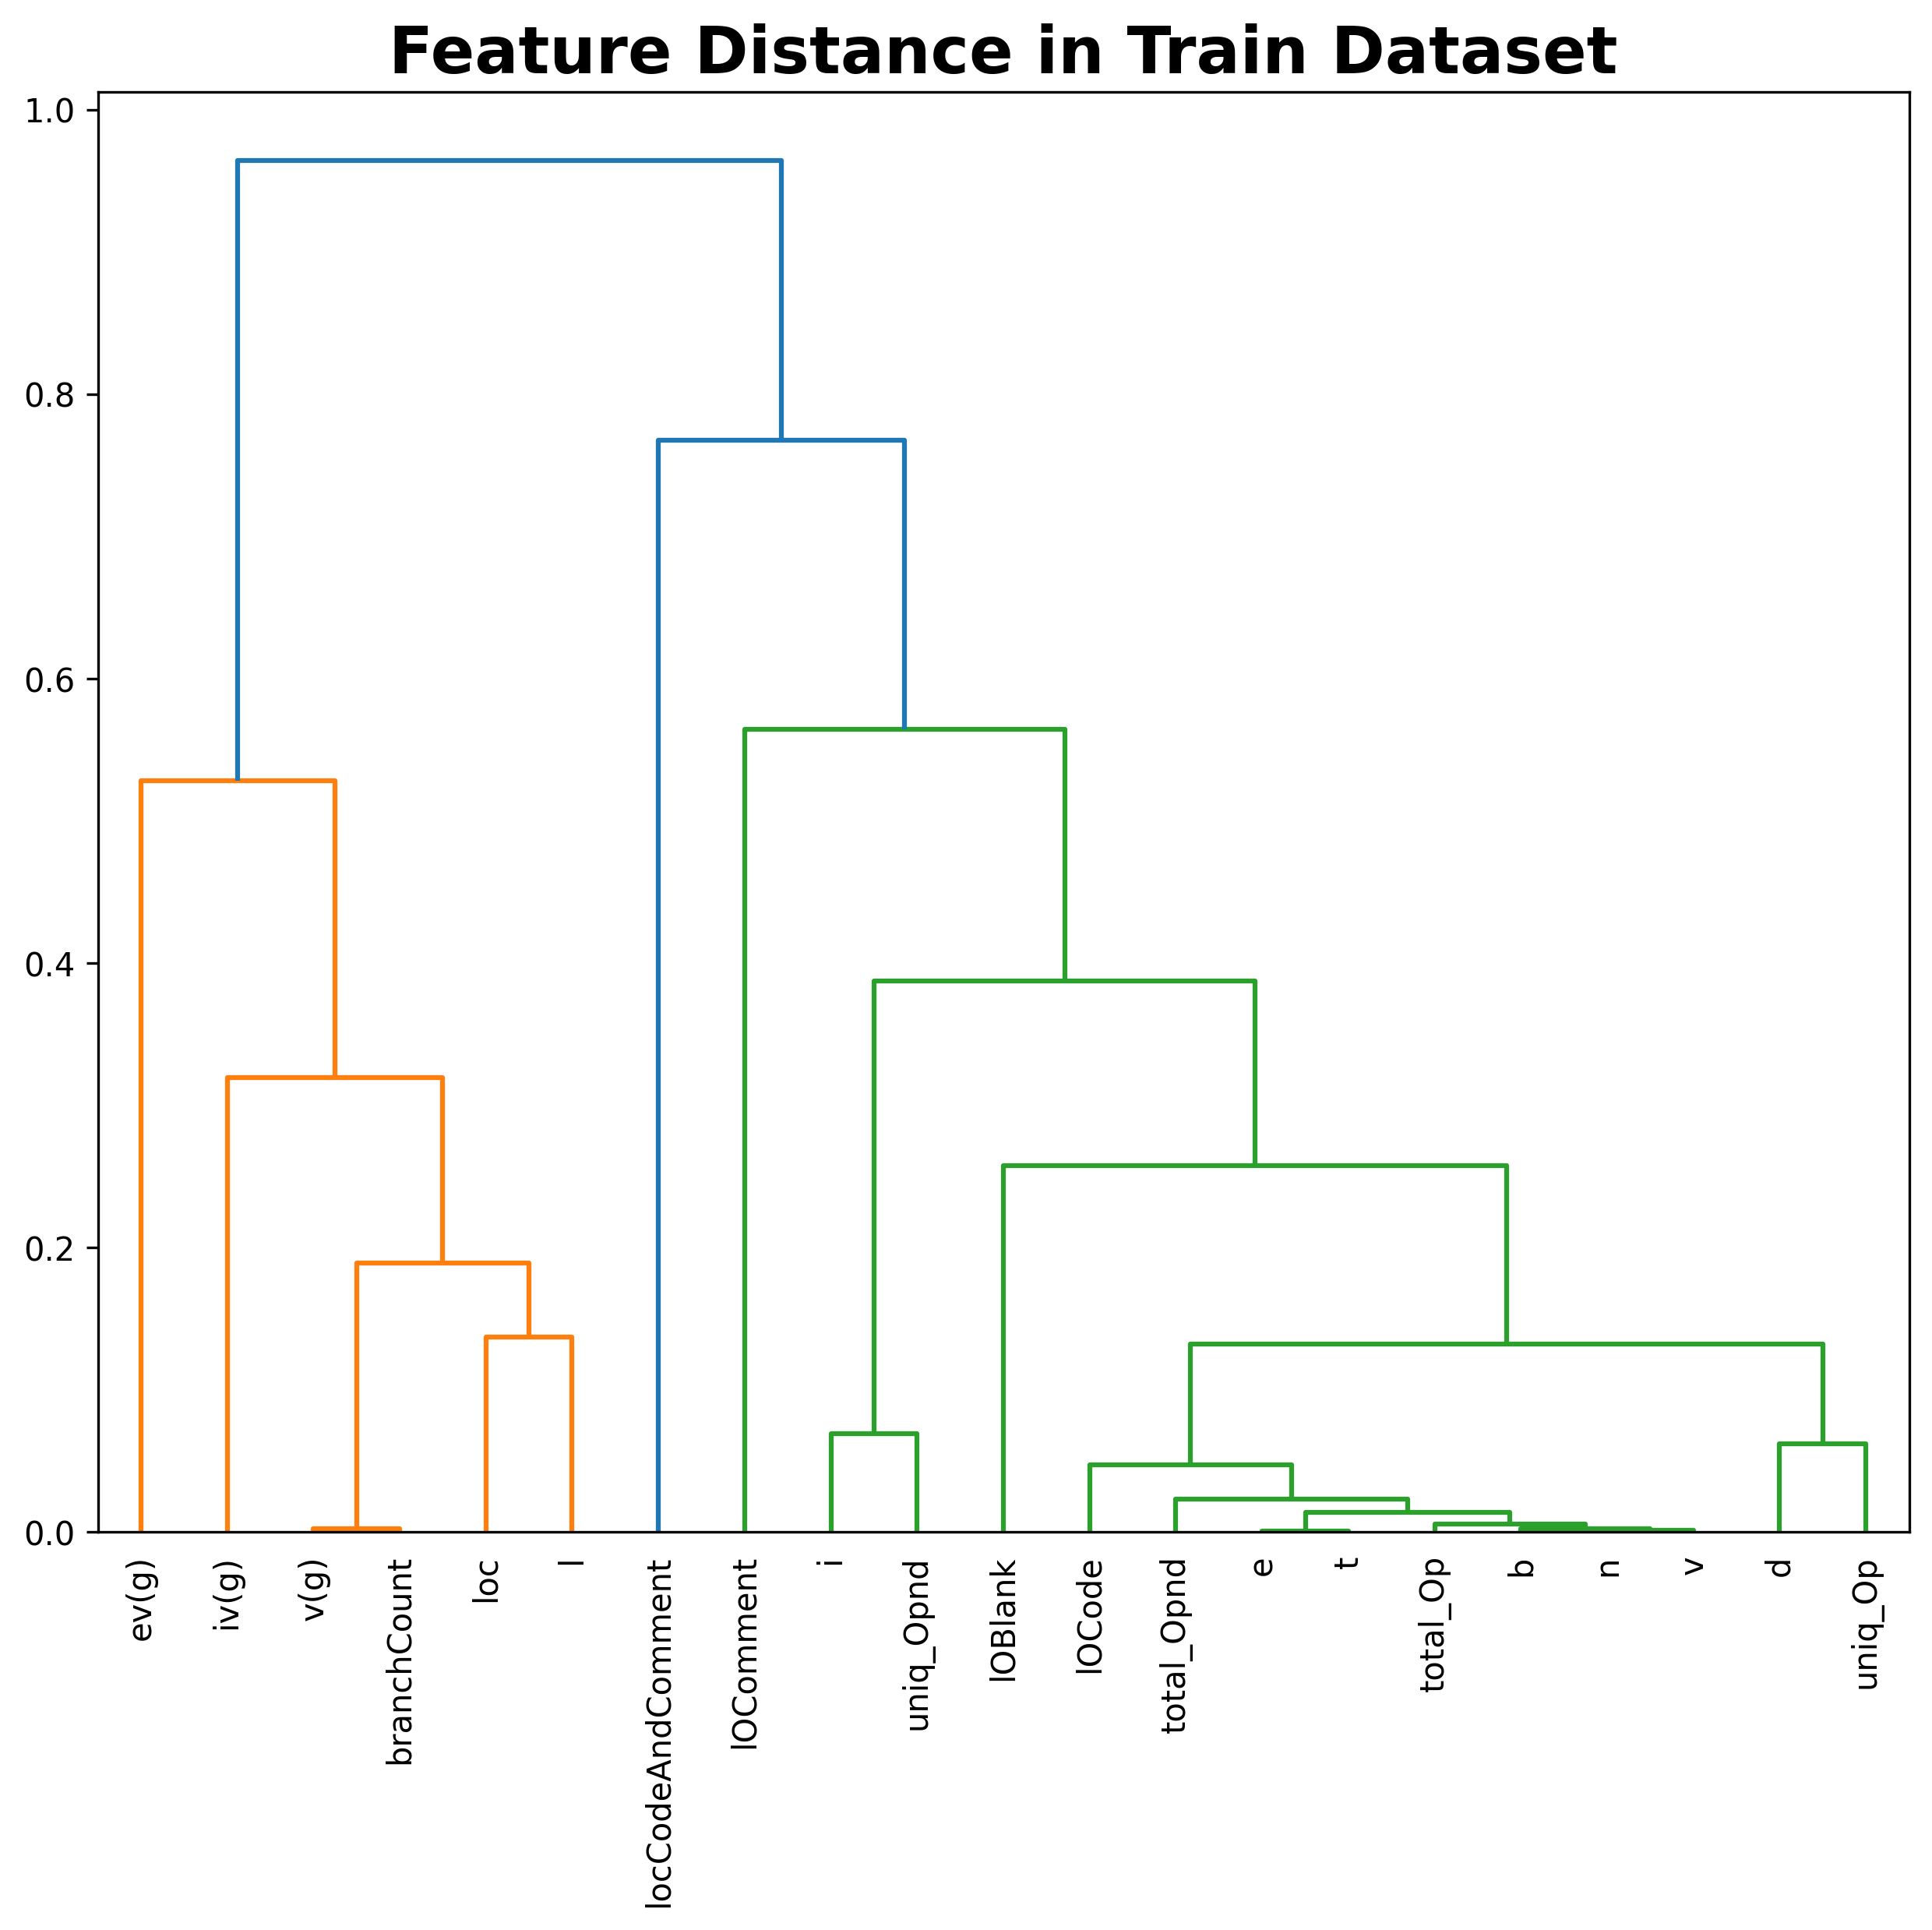

In [12]:
corr = X.corr(method = 'spearman')
dist_linkage = shc.linkage(squareform(1 - abs(corr)), 'complete')
    
plt.figure(figsize = (10, 8), dpi = 300)
dendro = shc.dendrogram(dist_linkage, labels=X.columns, leaf_rotation=90)
plt.title('Feature Distance in Train Dataset', weight = 'bold', size = 20)
plt.show()

Now we can grouping the duplicate features:

n, v, and b, t and e can be included in group 1.

After analyzing all the graphs, it was decided to remove all features from group 1 except feature n. And also remove the lOCodeAndComment and lOComment because they are not important.

In [13]:
X_ = X
X = X.drop(['v', 'b', 'e', 't', 'locCodeAndComment', 'lOComment'], axis=1)

In [14]:
X.shape

(101763, 15)

**Model**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.45, random_state=42)

In [16]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
model_with_early_stop=CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.3,
    early_stopping_rounds=20)
model_with_early_stop.fit(
    X_train,y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
model = CatBoostClassifier(
    iterations=500,
    random_seed=0,
    learning_rate=0.15
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_test, y_test)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

In [20]:

y_pred = model.predict_proba(X_test)[:, 1]
auc = sklearn.metrics.roc_auc_score(y_test, y_pred)


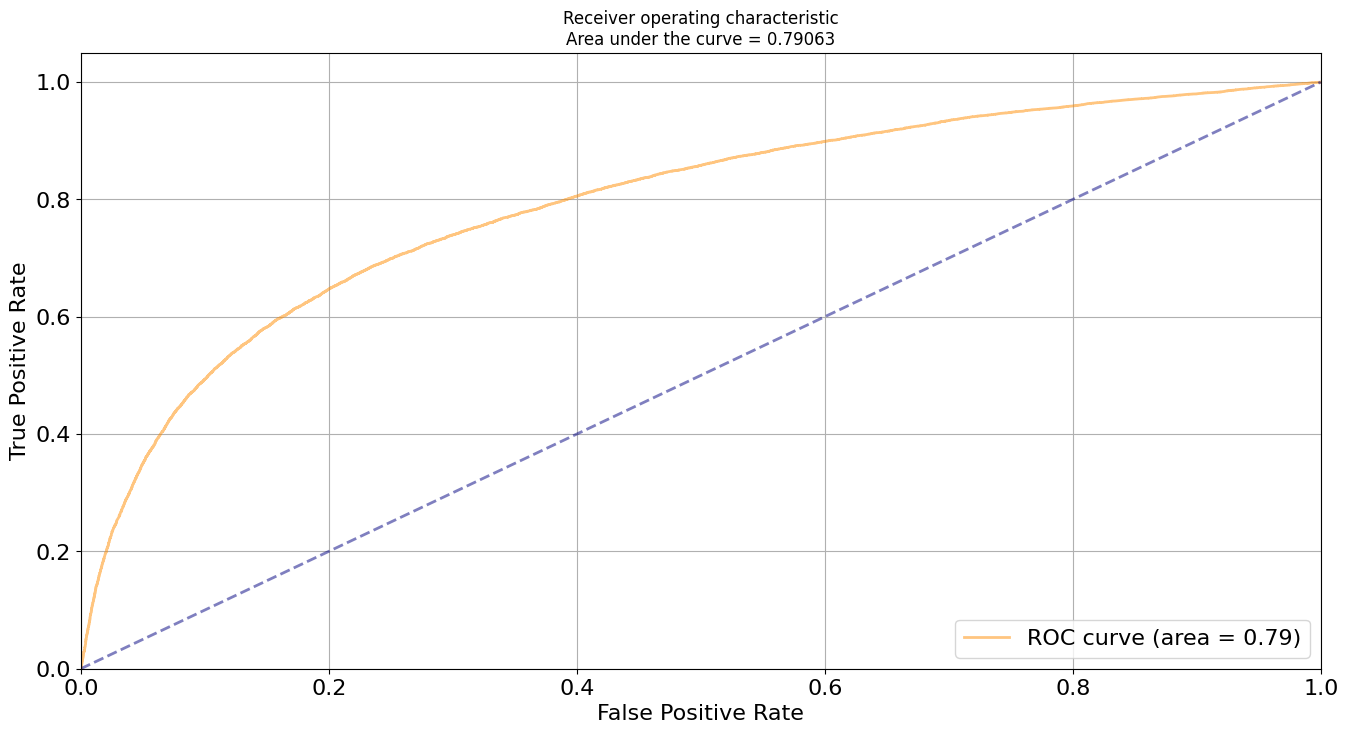

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title(f"Receiver operating characteristic\nArea under the curve = {auc:.5f}")
plt.legend(loc="lower right", fontsize=16)
plt.show()